In [1]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pymongo
import yaml
from tqdm.notebook import tqdm_notebook
from datetime import datetime
from time import time
from psynlig import pca_explained_variance_bar
from utils import (
    sliding_window_pd,
    apply_filter,
    filter_instances,
    flatten_instances_df,
    df_rebase,
    rename_df_column_values
)
from utils_visual import (
    plot_instance_time_domain,
    plot_instance_3d,
    plot_np_instance,
    plot_heatmap,
    plot_scatter_pca
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, SimpleRNN
import plotly.express as px

%load_ext autoreload
%autoreload 2

In [2]:
# Start time of execution
time_start = time()

In [3]:
# Load configuration
config_path = os.path.join(os.getcwd(), "config.yml")
with open(config_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [4]:
# Connect to MongoDB
client = pymongo.MongoClient(config["client"])
db = client[config["db"]]
coll = db[config["col"]]
found_keys = coll.distinct("label")
print("Existing DB keys:", found_keys)

Existing DB keys: ['class_A', 'class_B', 'class_C', 'class_D']


In [5]:
# Apply filter
data_cursor = coll.find()
data_list = list(data_cursor)
data_df_list = [pd.DataFrame(doc['data']) for doc in data_list]

In [6]:
# Transform the list of DataFrames to NumPy array
windows = np.array([df.values for df in data_df_list])
print("Transformed Data to NumPy array shape:", windows.shape)
print("NumPy Array Data:", windows)

Transformed Data to NumPy array shape: (2543, 70, 6)
NumPy Array Data: [[[0.69816628 0.23358722 0.78432263 0.51964505 0.45429729 0.53377466]
  [0.67767815 0.23256517 0.77141604 0.51434721 0.4788901  0.55228933]
  [0.6569603  0.23139523 0.75815792 0.50882764 0.50382074 0.57094926]
  ...
  [0.91214003 0.89876451 0.80928709 0.54400695 0.40861033 0.4905776 ]
  [0.91550521 0.90715309 0.8048551  0.57223706 0.40803649 0.48161032]
  [0.91857128 0.91525976 0.79919556 0.5999663  0.40770082 0.47271972]]

 [[0.3543214  0.17261065 0.45085898 0.36155683 0.81552743 0.78919774]
  [0.32609579 0.16338022 0.40484642 0.33892697 0.82767844 0.79879495]
  [0.29872935 0.15445177 0.35931299 0.31644171 0.8388654  0.80793905]
  ...
  [0.84133146 0.89156969 0.5319922  0.73248046 0.41455238 0.38956363]
  [0.83125716 0.88594003 0.51421356 0.74100005 0.41195197 0.38161213]
  [0.8213673  0.88032282 0.49758669 0.74932956 0.40917524 0.37381155]]

 [[0.27824601 0.16889466 0.05608391 0.11607447 0.70551116 0.79599953]
  [

In [7]:
# Flatten the 2D window instances
flattened_data_df = flatten_instances_df(data_df_list)
flattened_data_np = flattened_data_df.to_numpy()
print("Flattened NumPy Array shape:", flattened_data_np.shape)
print("Flattened NumPy Array:", flattened_data_np)

Flattened NumPy Array shape: (2543, 420)
Flattened NumPy Array: [[0.69816628 0.23358722 0.78432263 ... 0.5999663  0.40770082 0.47271972]
 [0.3543214  0.17261065 0.45085898 ... 0.74932956 0.40917524 0.37381155]
 [0.27824601 0.16889466 0.05608391 ... 0.85644616 0.34143368 0.27452395]
 ...
 [0.83001735 0.74291495 0.41231869 ... 0.25836288 0.57206581 0.45050537]
 [0.65403567 0.60879798 0.53535827 ... 0.46321841 0.51687981 0.40816624]
 [0.46326498 0.4212827  0.72071515 ... 0.67819352 0.62075425 0.31952034]]


In [8]:
# Train/Test split
X = flattened_data_df.to_numpy()
y = np.ones(2543, dtype=int)
y[1:563] = 0
y[564:1283] = 1
y[1284:2017] = 2
y[2018:2543] = 3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2034, 420)
X_test shape: (509, 420)
y_train shape: (2034,)
y_test shape: (509,)


In [9]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Dimensionality Reduction with PCA using the 1D (flattened) data
pca1 = PCA(n_components=1)
X_train_pca1 = pca1.fit_transform(X_train_scaled)
X_test_pca1 = pca1.transform(X_test_scaled)
print("X_train_pca1 shape:", X_train_pca1.shape)
print("X_test_pca1 shape:", X_test_pca1.shape)

X_train_pca1 shape: (2034, 1)
X_test_pca1 shape: (509, 1)


In [11]:
# PCA with 3 Components
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("X_train_pca shape:", X_train_pca.shape)
print("X_test_pca shape:", X_test_pca.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
train_pca_df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2', 'PC3'])
train_pca_df['label'] = y_train
# Plot the PCA results using plotly for interactive rotation
fig = px.scatter_3d(train_pca_df, x='PC1', y='PC2', z='PC3', color='label', title='3D PCA Scatter Plot')
fig.update_traces(marker=dict(size=2))
fig.show()

X_train_pca shape: (2034, 3)
X_test_pca shape: (509, 3)
y_train shape: (2034,)
y_test shape: (509,)


In [12]:
# PCA with X% of the variance of the dataset, for training the statistical AI Models
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("X_train_pca shape:", X_train_pca.shape)
print("X_test_pca shape:", X_test_pca.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_pca shape: (2034, 18)
X_test_pca shape: (509, 18)
y_train shape: (2034,)
y_test shape: (509,)


In [13]:
# Classifier - Statistical Learning
# Apply simple classifier
svm_classifier = SVC()
svm_classifier.fit(X_train_pca, y_train)
y_pred_svm = svm_classifier.predict(X_test_pca)
# Train Random Forest Classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_pca, y_train)
y_pred_rf = rf_classifier.predict(X_test_pca)
# Evaluate SVM Classifier
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_classification_report = classification_report(y_test, y_pred_svm)
print("SVM Classifier Accuracy:", svm_accuracy)
print("SVM Classification Report:\n", svm_classification_report)
# Evaluate Random Forest Classifier
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_classification_report = classification_report(y_test, y_pred_rf)
print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Random Forest Classification Report:\n", rf_classification_report)

SVM Classifier Accuracy: 0.9430255402750491
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       115
           1       0.97      0.99      0.98       146
           2       0.99      0.82      0.90       148
           3       0.82      1.00      0.90       100

    accuracy                           0.94       509
   macro avg       0.94      0.95      0.94       509
weighted avg       0.95      0.94      0.94       509

Random Forest Classifier Accuracy: 0.9508840864440079
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       115
           1       0.99      0.99      0.99       146
           2       0.94      0.90      0.92       148
           3       0.87      0.94      0.90       100

    accuracy                           0.95       509
   macro avg       0.95      0.95      0.95       509
weighted avg       0.

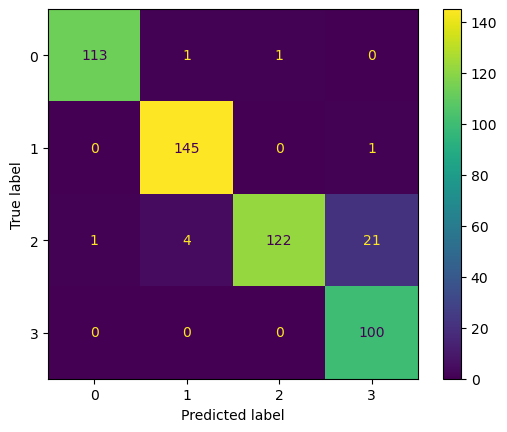

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       115
           1       0.97      0.99      0.98       146
           2       0.99      0.82      0.90       148
           3       0.82      1.00      0.90       100

    accuracy                           0.94       509
   macro avg       0.94      0.95      0.94       509
weighted avg       0.95      0.94      0.94       509



In [14]:
# Evaluate simple classifier
y_pred = svm_classifier.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred))

In [15]:
# Apply optimization with Grid Search and Cross-validation
# param_grid = config['fine_tune']['param_grid']
# grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=config['fine_tune']['cv'], verbose=config['fine_tune']['verbose'])
# grid_search.fit(X_train_pca, y_train)

In [16]:
# Evaluate optimized classifier
# best_svc = grid_search.best_estimator_
# y_pred_optimized = best_svc.predict(X_test_pca)
# cm_optimized = confusion_matrix(y_test, y_pred_optimized)
# disp_optimized = ConfusionMatrixDisplay(confusion_matrix=cm_optimized)
# disp_optimized.plot()
# plt.show()
# print(classification_report(y_test, y_pred_optimized))

In [17]:
# Classifier - Neural Network
# Reshape Data for CNN
X_train_2d = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_2d = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
print("X_train_2d shape:", X_train_2d.shape)
print("X_test_2d shape:", X_test_2d.shape)
y_np_array = np.array(y)
n_outputs = len(np.unique(y_np_array))
print("Number of outputs (classes) the model to predict:", n_outputs)

X_train_2d shape: (2034, 420, 1)
X_test_2d shape: (509, 420, 1)
Number of outputs (classes) the model to predict: 4


In [18]:
# Create the Neural Network (NN) Architecture and instantiate the model
model = tf.keras.models.Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_2d.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation='softmax'))
# Build the model by calling it on a batch of data
model.build(input_shape=(None, X_train_2d.shape[1], 1))

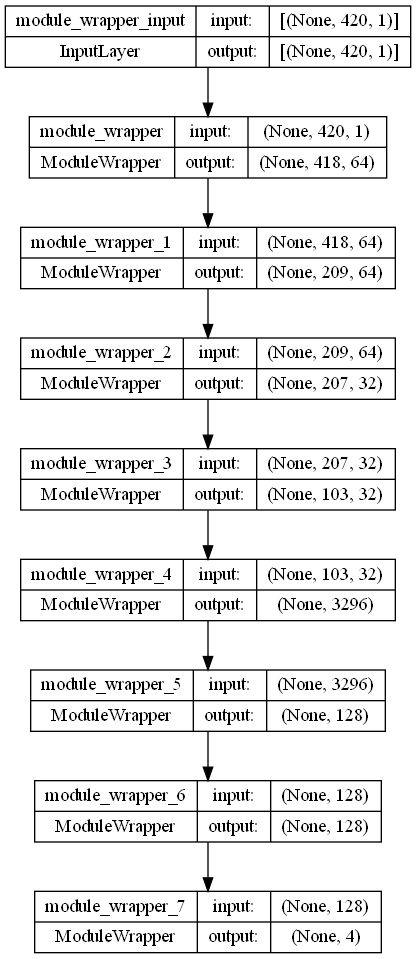

In [19]:
# Plot the Architecture of the TensorFlow model
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
# Plot the summary of the TensorFlow model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrapp  (None, 418, 64)          256       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 209, 64)          0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 207, 32)          6176      
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 103, 32)          0         
 pper)                                                           
                                                                 
 module_wrapper_4 (ModuleWra  (None, 3296)             0

In [21]:
# Build the NN model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [22]:
# Encode labels
from utils import encode_labels
y_train_encoded = encode_labels(y_train)
y_test_encoded = encode_labels(y_test)

In [23]:
# Train the NN model
cnn_history = model.fit(X_train_2d, y_train_encoded, epochs=100, batch_size=64, validation_split=0.2, verbose=config['fit']['verbose'])

Epoch 1/100
26/26 [==============================] - 4s 90ms/step - loss: 0.9486 - accuracy: 0.6275 - val_loss: 0.4249 - val_accuracy: 0.8747
Epoch 2/100
26/26 [==============================] - 1s 51ms/step - loss: 0.4645 - accuracy: 0.8482 - val_loss: 0.2653 - val_accuracy: 0.9238
Epoch 3/100
26/26 [==============================] - 2s 67ms/step - loss: 0.3336 - accuracy: 0.8881 - val_loss: 0.1927 - val_accuracy: 0.9337
Epoch 4/100
26/26 [==============================] - 1s 52ms/step - loss: 0.2849 - accuracy: 0.8949 - val_loss: 0.1909 - val_accuracy: 0.9337
Epoch 5/100
26/26 [==============================] - 1s 56ms/step - loss: 0.2520 - accuracy: 0.9060 - val_loss: 0.1611 - val_accuracy: 0.9459
Epoch 6/100
26/26 [==============================] - 1s 53ms/step - loss: 0.2209 - accuracy: 0.9170 - val_loss: 0.1492 - val_accuracy: 0.9509
Epoch 7/100
26/26 [==============================] - 1s 48ms/step - loss: 0.1845 - accuracy: 0.9312 - val_loss: 0.1303 - val_accuracy: 0.9509
Epoch 

In [24]:
# Evaluate the model on the test data
cnn_test_loss, cnn_test_acc = model.evaluate(X_test_2d, y_test_encoded)
print(f"Test accuracy: {cnn_test_acc:.4f}")

16/16 [==============================] - 0s 9ms/step - loss: 0.1684 - accuracy: 0.9627
Test accuracy: 0.9627


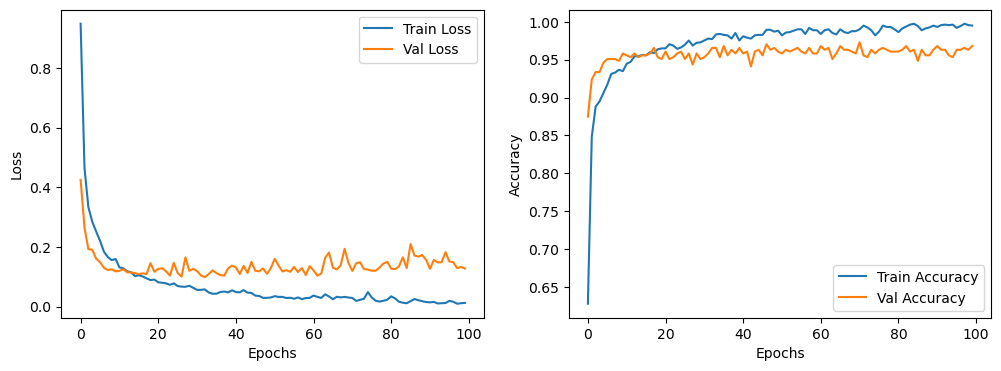

In [25]:
# Plot and interpret the learning curves: Loss and Accuracy based on the training and validation sets
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
# End time of execution
time_end = time()
print(f"Total execution time: {time_end - time_start:.2f} seconds")

Total execution time: 195.26 seconds


16/16 [==============================] - 1s 10ms/step
Predicted label for X[0]: 2 and real label: 2
Predicted label for X[1]: 1 and real label: 1
Predicted label for X[2]: 0 and real label: 0
Predicted label for X[3]: 2 and real label: 2
Predicted label for X[4]: 1 and real label: 1
Predicted label for X[5]: 0 and real label: 0
Predicted label for X[6]: 1 and real label: 2
Predicted label for X[7]: 1 and real label: 1
Predicted label for X[8]: 0 and real label: 0
Predicted label for X[9]: 1 and real label: 1
Predicted label for X[10]: 1 and real label: 1
Predicted label for X[11]: 2 and real label: 2
Predicted label for X[12]: 1 and real label: 1
Predicted label for X[13]: 0 and real label: 0
Predicted label for X[14]: 3 and real label: 3
Predicted label for X[15]: 1 and real label: 1
Predicted label for X[16]: 1 and real label: 1
Predicted label for X[17]: 0 and real label: 0
Predicted label for X[18]: 2 and real label: 2
Predicted label for X[19]: 2 and real label: 2
Predicted label 

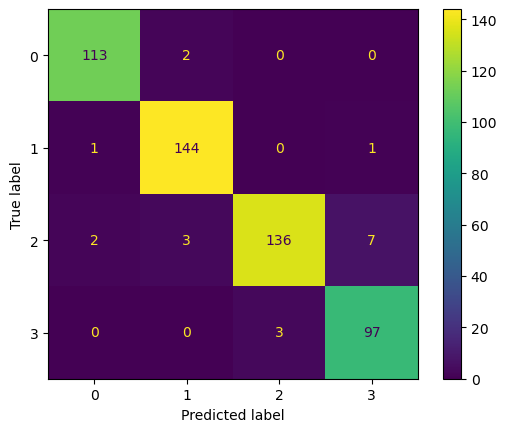

In [27]:
# Function to make predictions for all X values using the CNN model
def predict_labels_cnn(model, X):
    X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
    predictions = model.predict(X_reshaped)
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels

# Reshape the test data for CNN prediction
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Predict labels for the test set using CNN
y_pred_cnn = predict_labels_cnn(model, X_test_cnn)

# Print the predicted and real labels for each sample
for i in range(len(X_test_cnn)):
    print(f"Predicted label for X[{i}]: {y_pred_cnn[i]} and real label: {y_test[i]}")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.show()

# Create a DataFrame with predicted and real labels
predictions_df = pd.DataFrame({'Predicted Label': y_pred_cnn, 'Real Label': y_test})

64/64 [==============================] - 1s 8ms/step
Predicted label for X_train[0]: 0 and real label: 0
Predicted label for X_train[1]: 3 and real label: 3
Predicted label for X_train[2]: 3 and real label: 3
Predicted label for X_train[3]: 2 and real label: 2
Predicted label for X_train[4]: 3 and real label: 3
Predicted label for X_train[5]: 2 and real label: 2
Predicted label for X_train[6]: 1 and real label: 1
Predicted label for X_train[7]: 3 and real label: 3
Predicted label for X_train[8]: 1 and real label: 1
Predicted label for X_train[9]: 3 and real label: 3
Predicted label for X_train[10]: 0 and real label: 0
Predicted label for X_train[11]: 1 and real label: 1
Predicted label for X_train[12]: 3 and real label: 3
Predicted label for X_train[13]: 2 and real label: 2
Predicted label for X_train[14]: 1 and real label: 1
Predicted label for X_train[15]: 3 and real label: 3
Predicted label for X_train[16]: 2 and real label: 2
Predicted label for X_train[17]: 2 and real label: 2
Pre

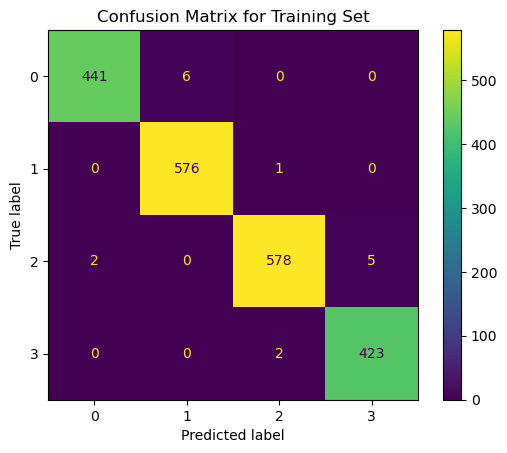

16/16 [==============================] - 0s 8ms/step
Predicted label for X_test[0]: 2 and real label: 2
Predicted label for X_test[1]: 1 and real label: 1
Predicted label for X_test[2]: 0 and real label: 0
Predicted label for X_test[3]: 2 and real label: 2
Predicted label for X_test[4]: 1 and real label: 1
Predicted label for X_test[5]: 0 and real label: 0
Predicted label for X_test[6]: 1 and real label: 2
Predicted label for X_test[7]: 1 and real label: 1
Predicted label for X_test[8]: 0 and real label: 0
Predicted label for X_test[9]: 1 and real label: 1
Predicted label for X_test[10]: 1 and real label: 1
Predicted label for X_test[11]: 2 and real label: 2
Predicted label for X_test[12]: 1 and real label: 1
Predicted label for X_test[13]: 0 and real label: 0
Predicted label for X_test[14]: 3 and real label: 3
Predicted label for X_test[15]: 1 and real label: 1
Predicted label for X_test[16]: 1 and real label: 1
Predicted label for X_test[17]: 0 and real label: 0
Predicted label for X

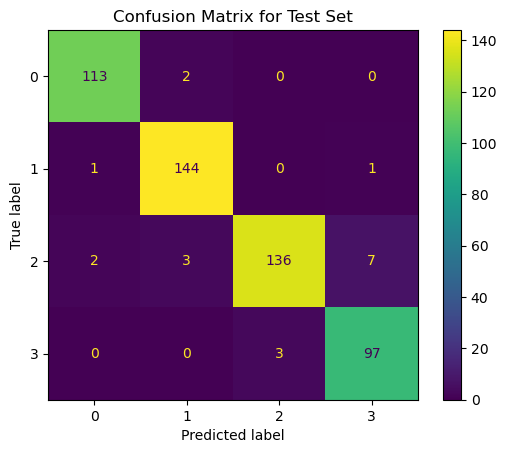

In [28]:
# Reshape the training data for CNN prediction
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

# Predict labels for the training set using CNN
y_pred_cnn_train = predict_labels_cnn(model, X_train_cnn)

# Print the predicted and real labels for each sample in the training set
for i in range(len(X_train_cnn)):
    print(f"Predicted label for X_train[{i}]: {y_pred_cnn_train[i]} and real label: {y_train[i]}")

# Generate the confusion matrix for the training set
cm_train = confusion_matrix(y_train, y_pred_cnn_train)

# Plot the confusion matrix for the training set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(cmap='viridis')
plt.title('Confusion Matrix for Training Set')
plt.show()

# Create a DataFrame with predicted and real labels for the training set
predictions_train_df = pd.DataFrame({'Predicted Label': y_pred_cnn_train, 'Real Label': y_train})

# Reshape the test data for CNN prediction
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Predict labels for the test set using CNN
y_pred_cnn_test = predict_labels_cnn(model, X_test_cnn)

# Print the predicted and real labels for each sample in the test set
for i in range(len(X_test_cnn)):
    print(f"Predicted label for X_test[{i}]: {y_pred_cnn_test[i]} and real label: {y_test[i]}")

# Generate the confusion matrix for the test set
cm_test = confusion_matrix(y_test, y_pred_cnn_test)

# Plot the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(cmap='viridis')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Create a DataFrame with predicted and real labels for the test set
predictions_test_df = pd.DataFrame({'Predicted Label': y_pred_cnn_test, 'Real Label': y_test})

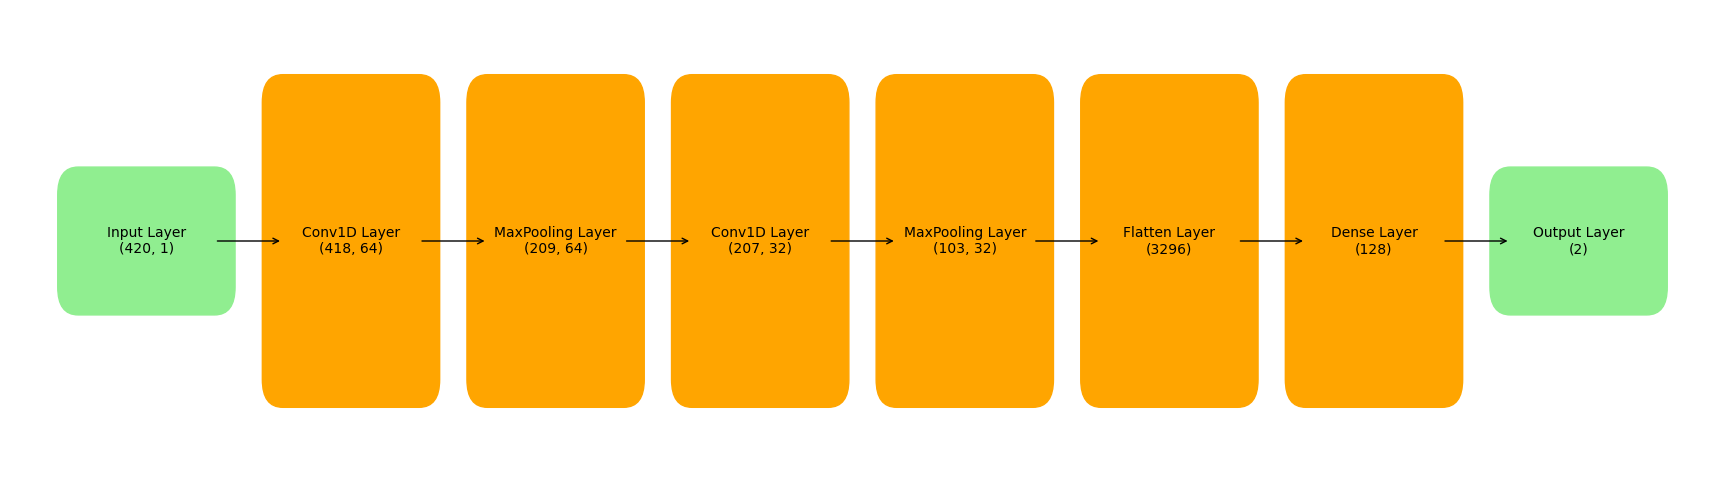

In [29]:
# Visualize the CNN model architecture
from matplotlib.patches import FancyBboxPatch

def draw_cnn(ax):
    input_box = FancyBboxPatch((0, 5), 2, 1, boxstyle="round,pad=0.3", color='lightgreen')
    ax.add_patch(input_box)
    ax.text(1, 5.5, 'Input Layer\n(420, 1)', ha='center', va='center', fontsize=10)
    conv1d_box = FancyBboxPatch((3, 4), 2, 3, boxstyle="round,pad=0.3", color='orange')
    ax.add_patch(conv1d_box)
    ax.text(4, 5.5, 'Conv1D Layer\n(418, 64)', ha='center', va='center', fontsize=10)
    maxpool_box = FancyBboxPatch((6, 4), 2, 3, boxstyle="round,pad=0.3", color='orange')
    ax.add_patch(maxpool_box)
    ax.text(7, 5.5, 'MaxPooling Layer\n(209, 64)', ha='center', va='center', fontsize=10)
    conv1d2_box = FancyBboxPatch((9, 4), 2, 3, boxstyle="round,pad=0.3", color='orange')
    ax.add_patch(conv1d2_box)
    ax.text(10, 5.5, 'Conv1D Layer\n(207, 32)', ha='center', va='center', fontsize=10)
    maxpool2_box = FancyBboxPatch((12, 4), 2, 3, boxstyle="round,pad=0.3", color='orange')
    ax.add_patch(maxpool2_box)
    ax.text(13, 5.5, 'MaxPooling Layer\n(103, 32)', ha='center', va='center', fontsize=10)
    flatten_box = FancyBboxPatch((15, 4), 2, 3, boxstyle="round,pad=0.3", color='orange')
    ax.add_patch(flatten_box)
    ax.text(16, 5.5, 'Flatten Layer\n(3296)', ha='center', va='center', fontsize=10)
    dense_box = FancyBboxPatch((18, 4), 2, 3, boxstyle="round,pad=0.3", color='orange')
    ax.add_patch(dense_box)
    ax.text(19, 5.5, 'Dense Layer\n(128)', ha='center', va='center', fontsize=10)
    output_box = FancyBboxPatch((21, 5), 2, 1, boxstyle="round,pad=0.3", color='lightgreen')
    ax.add_patch(output_box)
    ax.text(22, 5.5, 'Output Layer\n(2)', ha='center', va='center', fontsize=10)
    arrow_props = dict(facecolor='black', arrowstyle='<-')
    ax.annotate('', xy=(2, 5.5), xytext=(3, 5.5), arrowprops=arrow_props)
    ax.annotate('', xy=(5, 5.5), xytext=(6, 5.5), arrowprops=arrow_props)
    ax.annotate('', xy=(8, 5.5), xytext=(9, 5.5), arrowprops=arrow_props)
    ax.annotate('', xy=(11, 5.5), xytext=(12, 5.5), arrowprops=arrow_props)
    ax.annotate('', xy=(14, 5.5), xytext=(15, 5.5), arrowprops=arrow_props)
    ax.annotate('', xy=(17, 5.5), xytext=(18, 5.5), arrowprops=arrow_props)
    ax.annotate('', xy=(20, 5.5), xytext=(21, 5.5), arrowprops=arrow_props)

fig, ax = plt.subplots(figsize=(22, 6))
ax.set_xlim(-1, 24)
ax.set_ylim(3, 8)
ax.axis('off')
draw_cnn(ax)
plt.show()

In [30]:
# RNN Model
rnn_model = Sequential([
    SimpleRNN(64, activation='relu', input_shape=(420, 1)),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(4, activation='softmax')
])
rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the RNN model
rnn_history = rnn_model.fit(X_train_2d, y_train_encoded, epochs=100, batch_size=64, validation_split=0.2, verbose=1)
print("RNN Model Summary:")
rnn_model.summary()

# Evaluate the RNN model on the test data
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(X_test_2d, y_test_encoded)
print(f"RNN Test accuracy: {rnn_test_acc:.4f}")

Epoch 1/100
26/26 [==============================] - 5s 139ms/step - loss: 1.2431 - accuracy: 0.4186 - val_loss: 1.0523 - val_accuracy: 0.5455
Epoch 2/100
26/26 [==============================] - 3s 117ms/step - loss: 0.9703 - accuracy: 0.6103 - val_loss: 0.7894 - val_accuracy: 0.6904
Epoch 3/100
26/26 [==============================] - 3s 116ms/step - loss: 0.8311 - accuracy: 0.6632 - val_loss: 0.6949 - val_accuracy: 0.7641
Epoch 4/100
26/26 [==============================] - 3s 113ms/step - loss: 0.7368 - accuracy: 0.7056 - val_loss: 0.5834 - val_accuracy: 0.7740
Epoch 5/100
26/26 [==============================] - 3s 121ms/step - loss: 0.6676 - accuracy: 0.7326 - val_loss: 0.5274 - val_accuracy: 0.8034
Epoch 6/100
26/26 [==============================] - 4s 141ms/step - loss: 0.5962 - accuracy: 0.7855 - val_loss: 0.4831 - val_accuracy: 0.8378
Epoch 7/100
26/26 [==============================] - 4s 170ms/step - loss: 0.5647 - accuracy: 0.7898 - val_loss: 0.4598 - val_accuracy: 0.8206

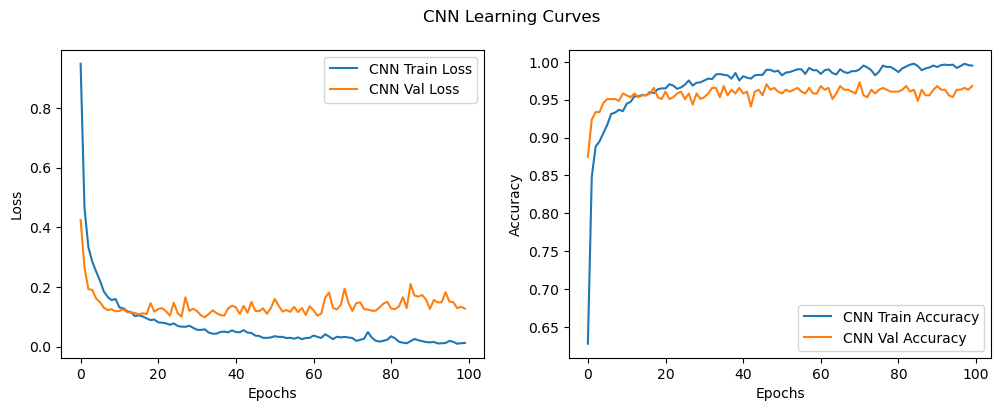

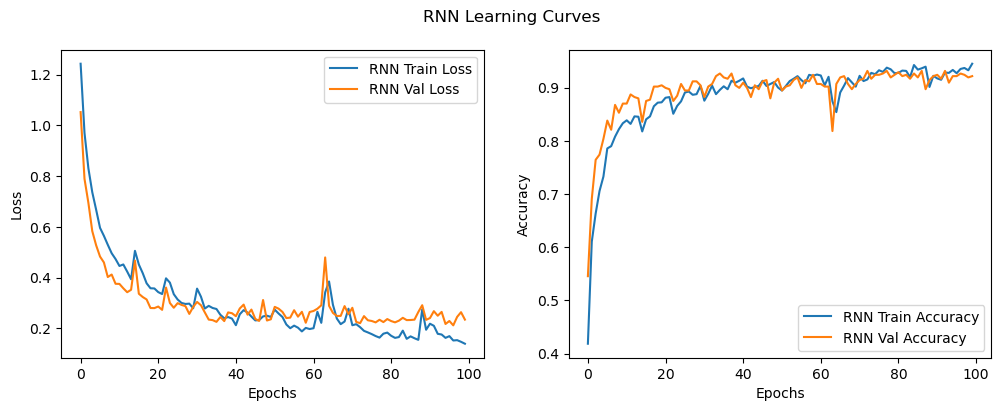

CNN Test accuracy: 0.9627
RNN Test accuracy: 0.8998


In [31]:
# Plot the learning curves for CNN
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='CNN Train Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='CNN Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.suptitle('CNN Learning Curves')
plt.show()

# Plot the learning curves for RNN
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['loss'], label='RNN Train Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['accuracy'], label='RNN Train Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.suptitle('RNN Learning Curves')
plt.show()
print(f"CNN Test accuracy: {cnn_test_acc:.4f}")
print(f"RNN Test accuracy: {rnn_test_acc:.4f}")

Predicted label for X_train[0]: 0 and real label: 0
Predicted label for X_train[1]: 3 and real label: 3
Predicted label for X_train[2]: 3 and real label: 3
Predicted label for X_train[3]: 2 and real label: 2
Predicted label for X_train[4]: 3 and real label: 3
Predicted label for X_train[5]: 2 and real label: 2
Predicted label for X_train[6]: 1 and real label: 1
Predicted label for X_train[7]: 3 and real label: 3
Predicted label for X_train[8]: 1 and real label: 1
Predicted label for X_train[9]: 3 and real label: 3
Predicted label for X_train[10]: 0 and real label: 0
Predicted label for X_train[11]: 1 and real label: 1
Predicted label for X_train[12]: 3 and real label: 3
Predicted label for X_train[13]: 3 and real label: 2
Predicted label for X_train[14]: 1 and real label: 1
Predicted label for X_train[15]: 3 and real label: 3
Predicted label for X_train[16]: 2 and real label: 2
Predicted label for X_train[17]: 2 and real label: 2
Predicted label for X_train[18]: 2 and real label: 2
Pre

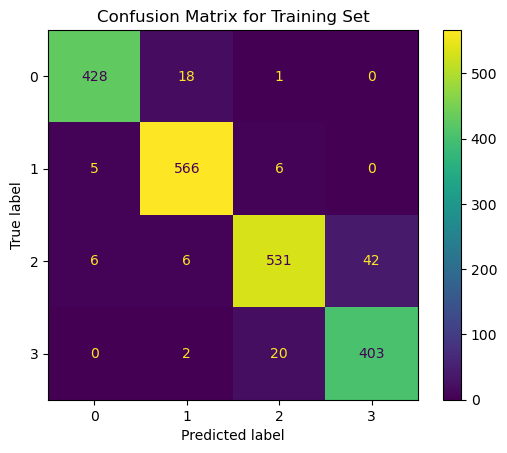

Predicted label for X_test[0]: 2 and real label: 2
Predicted label for X_test[1]: 1 and real label: 1
Predicted label for X_test[2]: 0 and real label: 0
Predicted label for X_test[3]: 2 and real label: 2
Predicted label for X_test[4]: 1 and real label: 1
Predicted label for X_test[5]: 1 and real label: 0
Predicted label for X_test[6]: 1 and real label: 2
Predicted label for X_test[7]: 1 and real label: 1
Predicted label for X_test[8]: 0 and real label: 0
Predicted label for X_test[9]: 1 and real label: 1
Predicted label for X_test[10]: 1 and real label: 1
Predicted label for X_test[11]: 2 and real label: 2
Predicted label for X_test[12]: 1 and real label: 1
Predicted label for X_test[13]: 0 and real label: 0
Predicted label for X_test[14]: 3 and real label: 3
Predicted label for X_test[15]: 1 and real label: 1
Predicted label for X_test[16]: 1 and real label: 1
Predicted label for X_test[17]: 0 and real label: 0
Predicted label for X_test[18]: 2 and real label: 2
Predicted label for X_

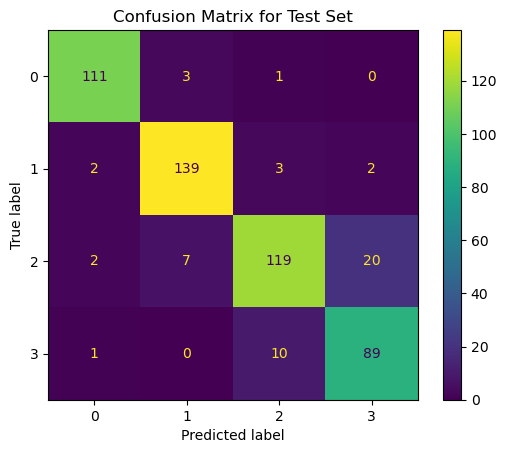

In [32]:
# Function to make predictions for all X values using the RNN model
def predict_labels_rnn(model, X):
    X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
    predictions = model.predict(X_reshaped)
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels

# Reshape the training data for RNN prediction
X_train_rnn = X_train_2d.reshape((X_train_2d.shape[0], X_train_2d.shape[1], 1))

# Predict labels for the training set using RNN
y_pred_rnn_train = predict_labels_rnn(rnn_model, X_train_rnn)

# Print the predicted and real labels for each sample in the training set
for i in range(len(X_train_rnn)):
    print(f"Predicted label for X_train[{i}]: {y_pred_rnn_train[i]} and real label: {y_train_encoded[i]}")

# Generate the confusion matrix for the training set
cm_train = confusion_matrix(y_train_encoded, y_pred_rnn_train)

# Plot the confusion matrix for the training set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(cmap='viridis')
plt.title('Confusion Matrix for Training Set')
plt.show()

# Create a DataFrame with predicted and real labels for the training set
predictions_train_df = pd.DataFrame({'Predicted Label': y_pred_rnn_train, 'Real Label': y_train_encoded})

# Reshape the test data for RNN prediction
X_test_rnn = X_test_2d.reshape((X_test_2d.shape[0], X_test_2d.shape[1], 1))

# Predict labels for the test set using RNN
y_pred_rnn_test = predict_labels_rnn(rnn_model, X_test_rnn)

# Print the predicted and real labels for each sample in the test set
for i in range(len(X_test_rnn)):
    print(f"Predicted label for X_test[{i}]: {y_pred_rnn_test[i]} and real label: {y_test_encoded[i]}")

# Generate the confusion matrix for the test set
cm_test = confusion_matrix(y_test_encoded, y_pred_rnn_test)

# Plot the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(cmap='viridis')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Create a DataFrame with predicted and real labels for the test set
predictions_test_df = pd.DataFrame({'Predicted Label': y_pred_rnn_test, 'Real Label': y_test_encoded})